In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import os.path as op
import xarray as xr
import hoi

/home/INT/brovelli.a/miniconda3/lib/python3.9/site-packages/scipy-1.7.1-py3.9-linux-x86_64.egg/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/INT/brovelli.a/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Directories

In [2]:
dir = '/home/INT/brovelli.a/code/acrho/data/spiking_model/project/netw/homog'
fname = op.join(dir, 'data.pkl')
df = pd.read_pickle(fname)

#### Create DataFrame

In [3]:
fr = []
for t in range(len(df)):

    # Spike matrix sparse 100 neurons x 10001 time points
    spike_matrix = np.zeros((100, int(1e4)+1))

    # Excitatory neurons
    time_raster_exc = df.at[t, 't_spike_exc']
    # Sample at msec resolution
    time_raster_exc = np.round(time_raster_exc, 3) * 1000
    # Make it an index
    ind_time = time_raster_exc.astype(int)
    ind_neuron = df.at[t, 'index_spike_exc']
    # Make a sparse matrix
    spike_matrix[ind_neuron, ind_time] = 1

    # Inhibitory neurons
    time_raster_inh = df.at[t, 't_spike_inh']
    # Sample at msec resolution
    time_raster_inh = np.round(time_raster_inh, 3) * 1000
    # Make it an index
    ind_time = time_raster_inh.astype(int)
    ind_neuron = df.at[t, 'index_spike_inh']
    # Make a sparse matrix and append to spike_matrix
    spike_matrix[ind_neuron, ind_time] = 1

    # Convolving with a boxcar filter
    from scipy.ndimage import convolve1d
    sigma = 10
    fr_trial = convolve1d(spike_matrix, np.ones(sigma), axis=1)

    # Binarise firing rate and fill with 0s and 1s
    fr_trial[fr_trial > 0] = 1

    # from scipy.ndimage import gaussian_filter1d
    # sigma = 30
    # fr_trial = gaussian_filter1d(spike_matrix, sigma, axis=1)

    # Append fr_trial to fr
    fr.append(fr_trial)

# make it DataArray
fr = xr.DataArray(fr, dims=['trials', 'neurons', 'times'])
# add attributes and coordinates
fr.attrs['units'] = 'probability'
fr.attrs['description'] = 'Firing probability'
fr.coords['trials'] = np.arange(200)
fr.coords['neurons'] = np.arange(100)
fr.coords['times'] = np.arange(10001)

#### Compute average firing probability for blocks of trials
Stim 1 = trials 1 to 100

Stim 2 = trials 101 to 200


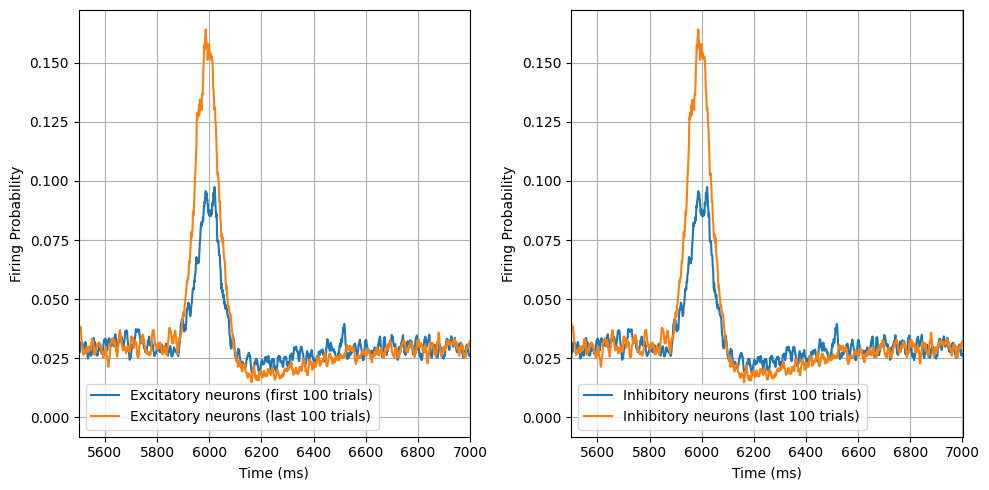

In [6]:
# Compute single-trial firing rate for the first 100 trials
fr_100 = fr.sel(trials=slice(0, 100))
fr_100 = fr_100.mean(dim='trials')
# Average over neurons 1 to 80
fr_exc = fr_100.sel(neurons=slice(0, 80))
fr_exc_s1 = fr_100.mean(dim='neurons')
# Average over neurons 81 to 100
fr_inh = fr_100.sel(neurons=slice(80, 100))
fr_inh_s1 = fr_100.mean(dim='neurons')

# Repeat for the last 100 trials
fr_100 = fr.sel(trials=slice(100, 200))
fr_100 = fr_100.mean(dim='trials')
# Average over neurons 1 to 80
fr_exc = fr_100.sel(neurons=slice(0, 80))
fr_exc_s2 = fr_100.mean(dim='neurons')
# Average over neurons 81 to 100
fr_inh = fr_100.sel(neurons=slice(80, 100))
fr_inh_s2 = fr_100.mean(dim='neurons')

# Plot the results fr_exc_s1 and fr_exc_s2, fr_inh_s1 and fr_inh_s2 in 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fr_exc_s1.plot(ax=axes[0], label='Excitatory neurons (first 100 trials)')
fr_exc_s2.plot(ax=axes[0], label='Excitatory neurons (last 100 trials)')
# crop the x axis around 6000 ms in 2 seconds interval
axes[0].set_xlim([5500, 7000])
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Firing Probability')
axes[0].legend()
# add grid
axes[0].grid()
fr_inh_s1.plot(ax=axes[1], label='Inhibitory neurons (first 100 trials)')
fr_inh_s2.plot(ax=axes[1], label='Inhibitory neurons (last 100 trials)')
axes[1].set_xlim([5500, 7000])
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Firing Probability')
axes[1].legend()
axes[1].grid()
plt.tight_layout()

## Compute task-related HOI with stimulus

#### Createa x and y

In [4]:
# Create x and y
# Create rando index for 8 neurons among the first 80 and 2 neurons among the last 20
ind_exc = np.random.choice(np.arange(80), 16, replace=False)
ind_inh = np.random.choice(np.arange(80, 100), 4, replace=False)
# Concatenate the indices
ind = np.concatenate((ind_exc, ind_inh))
# Create x
x = fr.data[:, ind, :]
# Crop the x axis around 6000 ms in 1.5 seconds interval
x = x[:, :, 5500:7000]
# Swap the second and third axes
# x = np.swapaxes(x, 1, 2)
x = x.astype(int)
# Create y
y = np.zeros((x.shape[0], 1))
y[:100] = 1
y[100:] = 2
y = y.astype(int)

#### O-info

#### Redundancy MMI

In [6]:
# Redundancy
from hoi.utils import get_nbest_mult
from hoi.metrics.red_mmi import RedundancyMMI

model = RedundancyMMI(x, y)
hoi = model.fit(minsize=3, maxsize=6, method="binning")

print(hoi)


Get list of multiplets


[[ 1.2439411e-03  1.2439411e-03  1.2439411e-03 ...  1.2439411e-03
   4.6587843e-08  4.6587843e-08]
 [-4.4425100e-08  7.4471813e-04  7.4471813e-04 ...  1.2439411e-03
   4.6587843e-08  4.6587843e-08]
 [ 4.6587843e-08  4.6587843e-08  7.4471813e-04 ...  1.2439411e-03
   4.6587843e-08  4.6587843e-08]
 ...
 [ 4.6587843e-08  4.6587843e-08  4.6587843e-08 ...  2.0939075e-07
   2.0939075e-07  2.0939075e-07]
 [ 4.6587843e-08  4.6587843e-08  4.6587843e-08 ...  8.0274598e-04
   8.8258978e-04  2.9704079e-04]
 [ 6.3883121e-08  6.3883121e-08  9.8260073e-04 ...  2.0939075e-07
   2.0939075e-07  2.0939075e-07]]


#### Plot all mutliplets

In [14]:
from hoi.plot import plot_landscape

<AxesSubplot:xlabel='Order', ylabel='Redundancy MMI [Bits]'>

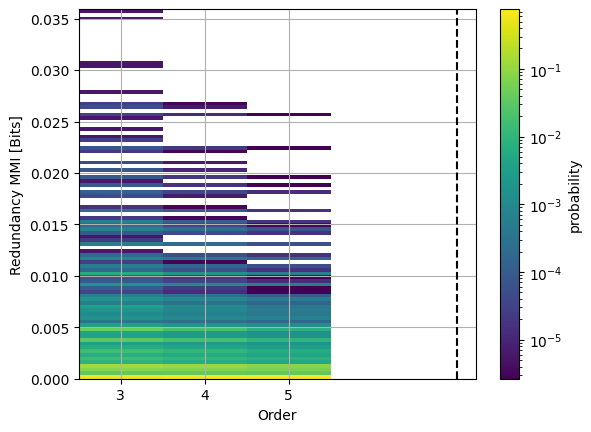

In [15]:
plot_landscape(hoi, model=model)


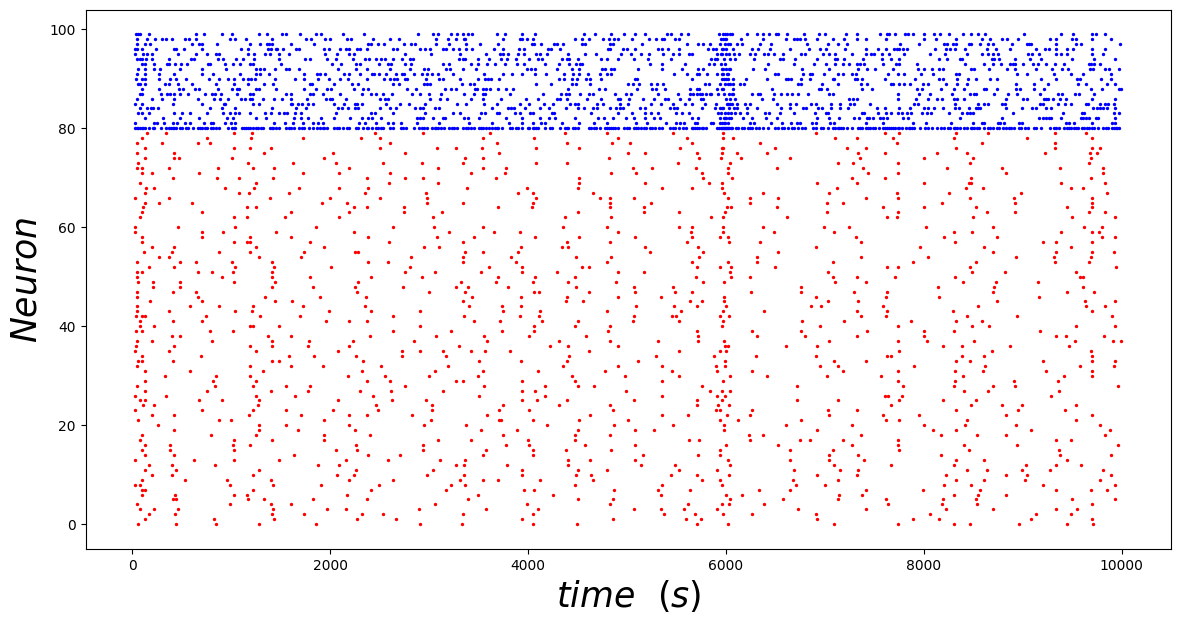

In [25]:
FIG=  []
fig=plt.figure(figsize=(14,7))
plt.scatter(time_raster_exc,exc_spike, s=2,color='red')
plt.scatter(time_raster_inh,inh_spike, s=2,color='blue')


plt.xlabel(r"$time \ \ (s) $",fontsize=25)
plt.ylabel(r"$Neuron \ \ $",fontsize=25)
plt.show()